# Spark serverless on Colaboratory

Powered by Open Data Studio [spark-serverless](https://github.com/open-datastudio/spark-serverless) project, it installs Apache Spark 3.0.0 in the serverless configuration.

## How it works
In Spark serverless configuration, the Spark driver runs in Colab, but executors are running on the cloud. So you can scale your job without managing the cluster.

## Cloud platform
Currently, the [spark-serverless](https://github.com/open-datastudio/spark-serverless) project runs executors on [staroid](https://staroid.com), the cloud platform for open-source projects. So you'll need a staroid account to try it.

Contribution for other cloud platform support is welcome!

## Get supported

Don't hesitate to create an [issue](https://github.com/open-datastudio/spark-serverless/issues) and [join our Slack channel](https://join.slack.com/t/opendatastudio/shared_invite/zt-fy2dsmb7-E9_UrBAh4UA47lzN5sUHUA).


## Get involved, get funded

[spark-serverless](https://github.com/open-datastudio/spark-serverless) is an MIT licensed **open-source** project, as a part of the [Open data studio](https://open-datastudio.io) project. Bugfixes, optimizations, new features, ... please feel free to create [pull requests](https://github.com/open-datastudio/spark-serverless/pulls).


If you're listed in Contributors page of the Github repository of the project, you'll get funded by [StarRank](https://staroid.com/site/starrank) when user run spark-serverless on staroid.


## FAQ

Q: Can I install spark-serverless in my laptop or in other environment?

A: Yes, It works everywhere. The same installation/configuration code in this notebook supposed to work in almost everywhere.


In [5]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/58Wd2_twMHA" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

# Install

## Setup Kubernetes cluster (staroid)

You need to do this only once, unless you remove the cluster.

  - sign in [staroid](https://staroid.com)
  - Kubernetes -> New Kubernetes cluster

## Configure spark serverless

Set following environment variables

  - `STAROID_ACCESS_TOKEN`
  - `STAROID_ACCOUNT`
  - `STAROID_CLUSTER`
  - `SPARK_INSTANCE_NAME`



In [ ]:
import os
# get a staroid api access token from https://staroid.com/settings/accesstokens
os.environ["STAROID_ACCESS_TOKEN"] = "<YOUR_ACCESS_TOKEN>"
os.environ["STAROID_ACCOUNT"] = "GITHUB/<your github account>"
os.environ["STAROID_CLUSTER"] = "<cluster name, created from 'Setup Kubernetes cluster' section>"
os.environ["SPARK_INSTANCE_NAME"] = "spark1" # instance name of spark serverless to create. You can change as you want. [a-z0-9-]

# Configure image -------------------------------------------------------
# Followings are configured for colab. You don't have to change anything here.
# If you'd like to use it in other environment, you can change followings accordingly.
#
# Spark driver and executor should use the same python version
# 'opendatastudio/spark-py' image includes multiple pythons inside.
# /home/spark/.pyenv/versions/3.6.9/bin/python3
# /home/spark/.pyenv/versions/3.7.7/bin/python3
# /home/spark/.pyenv/versions/3.8.1/bin/python3
# set PYSPARK_PYTHON environment variable based on the python version of the driver.
# In case of colab, we use python 3.6.
os.environ["SPARK_IMAGE"] = "opendatastudio/spark-py:v3.0.0-staroid"
os.environ["PYSPARK_PYTHON"] = "/home/spark/.pyenv/versions/3.6.9/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/local/bin/python"

## Download binaries

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz && tar -xf spark-3.0.0-bin-hadoop2.7.tgz
!pip install -q findspark
# staroid cli
!curl -o starctl -s -L https://github.com/staroids/starctl/releases/download/v0.0.1/starctl-linux-amd64 && chmod +x starctl
# kubectl cli
!curl -o kubectl -s -L https://storage.googleapis.com/kubernetes-release/release/v1.16.3/bin/linux/amd64/kubectl && chmod +x kubectl
# clone spark-serverless
!git clone https://github.com/open-datastudio/spark-serverless

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop2.7"
os.environ["STARCTL"] = "/content/starctl"
os.environ["KUBECTL"] = "/content/kubectl"



# Start spark-serverless

Starts a Kubernetes namespace and secure tunnel server on the cloud. It may take few seconds to a minute.

After successful start, secure tunnel is created and Kubernetes API server endpoint is available on http://localhost:8001.

In [ ]:
# start spark serverless
!spark-serverless/bin/ske_start.sh -o "$STAROID_ACCOUNT" -c "$STAROID_CLUSTER" -a "$SPARK_INSTANCE_NAME"

## Create spark session

Creating spark session will create initial number of executor configured

In [ ]:
# generate spark-defaults.conf
!spark-serverless/bin/ske_spark_conf.sh -o "$STAROID_ACCOUNT" -c "$STAROID_CLUSTER" -a "$SPARK_INSTANCE_NAME" > $SPARK_HOME/conf/spark-defaults.conf

import findspark
findspark.init()
from pyspark.sql import SparkSession

# This will creates spark executors on Kubernetes clusters.
# Initial run may take few minutes, in case of cluster provision new nodes for executors.
#
# spark.kubernetes.executor.label.pod.staroid.com/instance-type
#
#    Available values
#    - 'standard-2' (2CPU, 8GB mem)
#    - 'standard-4' (4CPU, 16GB mem)
#    - 'standard-8' (8CPU, 32GB mem)
#
#    Update 'spark.executor.cores' and 'spark.executor.memory' accordingly
#
# spark.kubernetes.executor.label.pod.staroid.com/spot
#
#    'true' to locate executors on Spot instance.
#
spark = SparkSession.builder \
  .appName("colab") \
  .config("spark.executor.cores", "4") \
  .config("spark.executor.memory", "16g") \
  .config("spark.kubernetes.executor.label.pod.staroid.com/instance-type", "standard-4") \
  .config("spark.kubernetes.executor.label.pod.staroid.com/spot", "false") \
  .config("spark.dynamicAllocation.initialExecutors", "2") \
  .config("spark.dynamicAllocation.minExecutors", "2") \
  .config("spark.dynamicAllocation.maxExecutors", "10") \
  .config("spark.driver.host", "driver-spark-serverless") \
  .config("spark.driver.bindAddress", "0.0.0.0") \
  .config("spark.jars.packages", "com.amazonaws:aws-java-sdk-pom:1.11.814,org.apache.hadoop:hadoop-aws:2.7.7") \
  .config("spark.hadoop.fs.s3a.access.key", "<optionally, set your aws access key to test with large dataset>") \
  .config("spark.hadoop.fs.s3a.secret.key", "<optionally, set your aws secret key to test with large dataset>") \
  .getOrCreate()

# Use spark!

Initial run may take 1-5 minutes as cluster provision new nodes for spark executors.

In [ ]:
df = spark.createDataFrame([{"hello": "world"} for x in range(1000)])
df.show(3)

## Open Spark UI

Run following cell to get Spark UI address.

In [ ]:
%%bash
STAROID_NAMESPACE=`/content/kubectl --server localhost:8001 get pods 2>&1 | sed 's/.*system[:][^:]*[:]\([^:]*\).*/\1/g'`
STAROID_SERVICE_DOMAIN=`/content/kubectl --server localhost:8001 -n $STAROID_NAMESPACE get configmap staroid-envs -o yaml | grep STAROID_SERVICE_DOMAIN | sed 's/[^:]*..\(.*\)/\1/g'`
INSTANCE_NAME=${INSTANCE_NAME:-spark-serverless}

echo "https://p4040-spark-ui-$INSTANCE_NAME--$STAROID_SERVICE_DOMAIN"

## Let's try larger dataset

In case you created your SparkSession with `spark.hadoop.fs.s3a.access.key` and `spark.hadoop.fs.s3a.secret.key` set, let's load public dataset from s3a://us-east-1.elasticmapreduce.samples/flightdata/input/

The data set is around 4 GB compressed (79 GB uncompressed) and contains 162,212,419 rows


In [ ]:
dataLocation = "s3a://us-east-1.elasticmapreduce.samples/flightdata/input/"
df = spark.read.parquet(dataLocation)
df.createOrReplaceTempView("flights_df")

In [ ]:
%%time
spark.sql("select * from flights_df limit 10").show()

In [ ]:
%%time
spark.sql("select flightdate, count(1) from flights_df group by flightdate order by flightdate").show()

# Shutdown & Clean up

In [ ]:
# stop spark instance on the cloud. It does not completely destroy. So it keeps Kubernetes resources (such as ConfigMap, Secret, PersistentVolumeClaim).
!spark-serverless/bin/ske_stop.sh -o "$STAROID_ACCOUNT" -c "$STAROID_CLUSTER" -a "$SPARK_INSTANCE_NAME"

## Important

Visit your Kubernetes cluster page in [staroid](https://staroid.com) and make sure the spark instance is stopped or terminated to prevent unintended usage charges.

You can always stop/terminate instance from the staroid management console, if `ske_stop.sh` command above fails.



# Performance test result

Following is a very simple benchmark result using 2 Spark SQL queries in this notebook.

| Name      | value |
| ---------- | ------------ |
| Test data | s3a://us-east-1.elasticmapreduce.samples/flightdata/input/, parquet format, 4 GB compressed (79 GB uncompressed) and contains 162,212,419 rows |
| Test data location | AWS us-east-1 region |
| Spark executor location | GCP us-west1 region |
| Spark driver location | Google Colab |
| Driver mode | Client mode |

The test setup does not assume the optimal case, such as everything is co-located. Instead, data and executors and a driver are all located in different regions or clouds.

We tested with a couple of combinations of #executors and instance types.


## First query

In [ ]:
import pandas as pd  
    
benchmarkResultQuery1 = [
  ['colab', 195],
  ['standard-2 x1', 79],
  ['standard-2 x2', 50],
  ['standard-2 x4', 36],
  ['standard-8 x8', 32],
  ['standard-4 x1', 40],
  ['standard-4 x2', 30],
  ['standard-4 x4', 28],
  ['standard-8 x1', 25],
  ['standard-8 x2', 21],
]

df1 = pd.DataFrame(benchmarkResultQuery1, columns =['Executors', 'Elapsed (sec)'])
df1

,Executors,Elapsed (sec)
0,colab,195
1,standard-2 x1,79
2,standard-2 x2,50
3,standard-2 x4,36
4,standard-8 x8,32
5,standard-4 x1,40
6,standard-4 x2,30
7,standard-4 x4,28
8,standard-8 x1,25
9,standard-8 x2,21


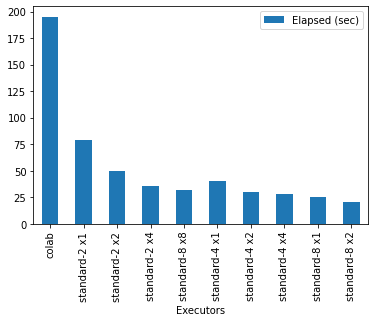

In [ ]:
df1.plot.bar(x="Executors")

## Second Query

In [ ]:
benchmarkResultQuery2 = [
  ['colab', 74],
  ['standard-2 x1', 74],
  ['standard-2 x2', 47],
  ['standard-2 x4', 36],
  ['standard-8 x8', 28],
  ['standard-4 x1', 46],
  ['standard-4 x2', 32],
  ['standard-4 x4', 26],
  ['standard-8 x1', 34],
  ['standard-8 x2', 30],
]    


df2 = pd.DataFrame(benchmarkResultQuery2, columns =['Executors', 'Elapsed'])
df2

,Executors,Elapsed
0,colab,74
1,standard-2 x1,74
2,standard-2 x2,47
3,standard-2 x4,36
4,standard-8 x8,28
5,standard-4 x1,46
6,standard-4 x2,32
7,standard-4 x4,26
8,standard-8 x1,34
9,standard-8 x2,30


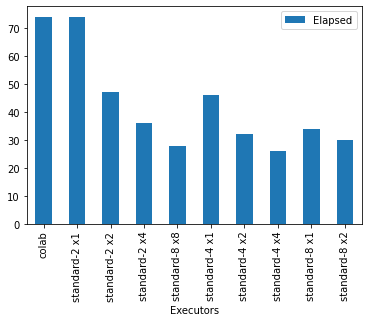

In [ ]:
df2.plot.bar(x="Executors")

## Conclusion

Even though it is not the optimal configuration, that data, driver, and executors are all running in a different location, we can still see significant performance improvement compare to default Colab runtime.

The limiting factor of the performance, in this case, could be parallel access to the storage, rather than memory or CPU. 

Although this is a very simple test and doesn't represent other types of queries that may bounded to CPU, we can see it is much faster than Colab's default runtime and it scales well as the number of executors increases.